A CNN on the global views 500x500

In [136]:
import tensorflow as tf
import time
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from helpers.data_loading import *
from helpers.CNN_layers import ConvLayer, DenseLayer
from spearman import score_function

In [2]:
y, _ = load_labels()  # scores between 0 and 25 for training instances
y = y.reshape((-1,1))

In [211]:
tf.reset_default_graph()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement=True
sess = tf.InteractiveSession(config=config)

input_tf = tf.placeholder(tf.float32, shape=[None, 200, 200, 1])
y_tf = tf.placeholder(tf.float32, shape=[None, 1])

conv1 = ConvLayer(input_tf, 16)
conv1.max_pool()

conv2 = ConvLayer(conv1.output, 32)
conv2.max_pool()

conv3 = ConvLayer(conv2.output, 64)
conv3.max_pool()

fc1 = DenseLayer(conv3.output, 256)
fc1.drop_out()

fc2 = DenseLayer(fc1.output, 1)

# final_output = 24. * (1 / (1 + tf.exp(- fc2.output)))  # logit to normalize
final_output = fc2.output

In [212]:
mse = tf.reduce_mean((final_output - y_tf)**2)
learning_rate = tf.placeholder(tf.float32, shape=[])
train_step = tf.train.AdamOptimizer(learning_rate).minimize(mse)

In [213]:
sess.run(tf.global_variables_initializer())

In [214]:
mse.eval(feed_dict={
    input_tf: global_views_batch(np.arange(1, 51))[0].reshape((-1, 200, 200, 1)), 
    y_tf: y[0:50,:], 
    fc1.keep_prob: 1.0
})

256704.22

In [215]:
type(local_views_batch(np.arange(1, 11))[0][0,0,0])

numpy.float32

In [216]:
# WARNING indices for y and when calling global_views_batch differ from 1
# we create a quick batch generator for the training and the testing

# sample train/test indices # WARNING indexed from 1!!!
train = np.random.choice(range(1, 10**4), size = 9500, replace = False)
test = np.setdiff1d(np.arange(1, 10**4), train)

def train_batch(batch_size=50):
    nb_batch = len(train) // batch_size
    while 1:
        for i in range(nb_batch):
            in_batch = train[i*batch_size:((i+1)*batch_size)]
            X_batch, _ = global_views_batch(in_batch)
            y_batch = y[in_batch-1]  # WARNING Y is indexed from 0!!!
            y_batch = y_batch.astype(np.float32)
            yield X_batch/255., y_batch
            
def test_batch(batch_size=50):
    nb_batch = len(test) // batch_size
    while 1:
        for i in range(nb_batch):
            in_batch = test[i*batch_size:((i+1)*batch_size)]
            X_batch, _ = global_views_batch(in_batch)
            y_batch = y[in_batch-1]  # WARNING Y is indexed from 0!!!
            y_batch = y_batch.astype(np.float32)
            yield X_batch/255., y_batch

In [217]:
train_gen = train_batch(100)
test_gen = test_batch(300)

In [218]:
X_test, y_test = next(test_gen)
X_test = X_test.reshape((-1, 200, 200, 1))
print X_test.shape
print y_test.shape

(300, 200, 200, 1)
(300, 1)


In [219]:
def epoch(lr=1e-4):
    X_train, y_train = next(train_gen)
    X_train = X_train.reshape((-1, 200, 200, 1))
    # X_test, y_test = next(test_gen)
    # X_test = X_test.reshape((-1, 200, 200, 1))
    train_step.run(feed_dict={
        input_tf: X_train, 
        y_tf: y_train,
        fc1.keep_prob: 0.5,
        learning_rate: lr
    })
    train_mse = sess.run(mse, feed_dict={input_tf:X_train, y_tf: y_train, fc1.keep_prob: 1.0})
    
    # preds on test
    preds = final_output.eval(feed_dict={input_tf: X_test, fc1.keep_prob: 1.0})
    #print preds.flatten()[0:10]
    test_mse = np.mean((preds - y_test)**2)
    current_spearman = score_function(y_pred=np.round(preds), y_true=y_test)
    
    return {"train_mse":train_mse, "test_mse":test_mse, "test_spearman":current_spearman, 'lr': lr}

In [220]:
learning_history = {'iterations':[], 'train_mse':[], 'test_mse':[], 'test_spearman':[], 'lr':[]}

def update_history(learning_history, epoch):
    learning_history['iterations'].append(len(learning_history['iterations']))
    for name in ['train_mse', 'test_mse', 'test_spearman', 'lr']:
        learning_history[name].append(epoch[name])

i=999


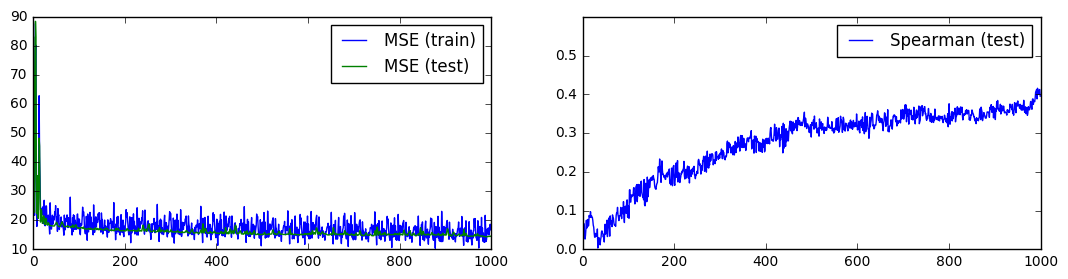

In [221]:
for i in range(1000):
    update_history(learning_history, epoch(lr=10**-4))
    if (i+1) % 5 == 0:
        clear_output()
        print "i=%i"%i
        f, axarr = plt.subplots(1, 2, figsize=(13, 3))
        axarr[0].plot(learning_history['iterations'][:-1000:-1][::-1], learning_history['train_mse'][:-1000:-1][::-1], label="MSE (train)")
        axarr[0].plot(learning_history['iterations'][:-1000:-1][::-1], learning_history['test_mse'][:-1000:-1][::-1], label="MSE (test)")
        axarr[1].plot(learning_history['iterations'], learning_history['test_spearman'], label="Spearman (test)")
        axarr[0].legend()
        axarr[1].legend()
        axarr[1].set_ylim((0,0.6))
        plt.show()

i=999


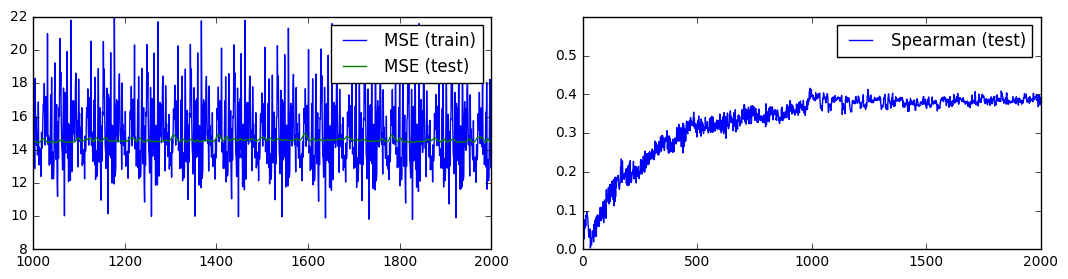

In [222]:
for i in range(1000):
    update_history(learning_history, epoch(lr=10**-5))
    if (i+1) % 5 == 0:
        clear_output()
        print "i=%i"%i
        f, axarr = plt.subplots(1, 2, figsize=(13, 3))
        axarr[0].plot(learning_history['iterations'][:-1000:-1][::-1], learning_history['train_mse'][:-1000:-1][::-1], label="MSE (train)")
        axarr[0].plot(learning_history['iterations'][:-1000:-1][::-1], learning_history['test_mse'][:-1000:-1][::-1], label="MSE (test)")
        axarr[1].plot(learning_history['iterations'], learning_history['test_spearman'], label="Spearman (test)")
        axarr[0].legend()
        axarr[1].legend()
        axarr[1].set_ylim((0,0.6))
        plt.show()

i=999


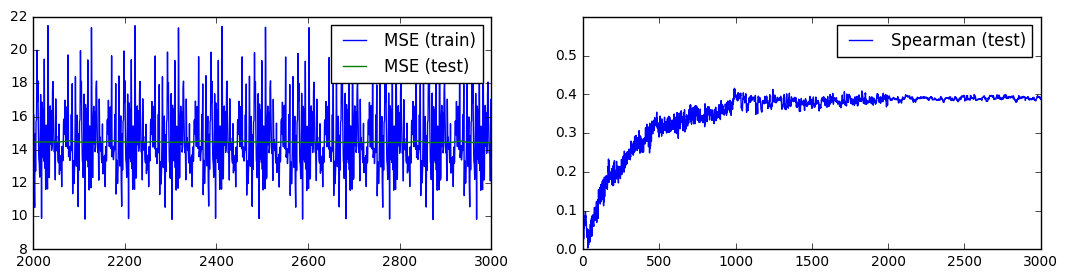

In [223]:
for i in range(1000):
    update_history(learning_history, epoch(lr=10**-6))
    if (i+1) % 5 == 0:
        clear_output()
        print "i=%i"%i
        f, axarr = plt.subplots(1, 2, figsize=(13, 3))
        axarr[0].plot(learning_history['iterations'][:-1000:-1][::-1], learning_history['train_mse'][:-1000:-1][::-1], label="MSE (train)")
        axarr[0].plot(learning_history['iterations'][:-1000:-1][::-1], learning_history['test_mse'][:-1000:-1][::-1], label="MSE (test)")
        axarr[1].plot(learning_history['iterations'], learning_history['test_spearman'], label="Spearman (test)")
        axarr[0].legend()
        axarr[1].legend()
        axarr[1].set_ylim((0,0.6))
        plt.show()

In [231]:
for i in range(10):
    update_history(learning_history, epoch(lr=10**-7))
    if (i+1) % 5 == 0:
        clear_output()
        print "i=%i"%i
        f, axarr = plt.subplots(1, 2, figsize=(13, 3))
        axarr[0].plot(learning_history['iterations'], learning_history['train_mse'], label="MSE (train)")
        axarr[0].plot(learning_history['iterations'], learning_history['test_mse'], label="MSE (test)")
        axarr[1].plot(learning_history['iterations'], learning_history['test_spearman'], label="Spearman (test)")
        axarr[0].legend()
        axarr[1].legend()
        axarr[1].set_ylim((0,0.6))
        plt.show()

StopIteration: 

In [181]:
final_output.eval(feed_dict={input_tf:X_test, fc1.keep_prob: 1.0})

array([[ 12.21773052],
       [ 14.24792767],
       [ 11.90218067],
       [ 12.60388279],
       [ 13.58035278],
       [ 12.99759769],
       [ 12.9631443 ],
       [ 12.02106476],
       [ 11.57773972],
       [ 14.99674702],
       [ 13.35687256],
       [ 15.70601845],
       [ 11.62931538],
       [ 10.97200966],
       [ 11.37621117],
       [ 13.40179157],
       [ 11.90528965],
       [ 11.61917877],
       [ 12.85516548],
       [ 11.50734043],
       [ 12.4366169 ],
       [ 10.7765007 ],
       [ 11.98230839],
       [ 14.90376759],
       [ 13.45564175],
       [ 11.08353138],
       [ 13.37368393],
       [ 11.73821068],
       [ 10.61782074],
       [ 12.65730762],
       [ 11.4076786 ],
       [ 12.92516518],
       [ 12.06490135],
       [ 12.13104057],
       [ 11.59654045],
       [ 10.74963474],
       [ 12.24654579],
       [ 11.24514961],
       [ 13.43876266],
       [ 11.89245033],
       [ 10.5715332 ],
       [ 12.17719555],
       [ 11.16862583],
       [ 11

In [194]:
learning_history['train_mse'][:-1000:-1][::-1]

[20.652962,
 16.509729,
 20.93803,
 18.182318,
 14.313332,
 20.059155,
 20.313774,
 22.292755,
 21.003839,
 24.255688,
 14.901104,
 21.035194,
 14.721121,
 21.419346,
 20.93285,
 20.654066,
 15.1795,
 15.620175,
 21.25761,
 19.345274,
 18.672741,
 21.499504,
 18.410463,
 23.621531,
 20.944057,
 22.952911,
 26.412554,
 22.115108,
 21.814304,
 16.648064,
 17.272287,
 22.896381,
 14.157557,
 18.193899,
 20.907045,
 20.41102,
 19.25951,
 20.262547,
 23.023642,
 17.787716,
 20.57765,
 26.43869,
 23.323555,
 20.94957,
 21.091038,
 19.160574,
 24.510403,
 16.915354,
 23.669239,
 19.326677,
 22.082283,
 18.818481,
 20.376724,
 19.860846,
 17.465242,
 18.512424,
 24.369532,
 20.410721,
 16.745853,
 19.598873,
 16.878931,
 24.225035,
 20.77763,
 18.375603,
 16.959431,
 22.812637,
 21.242044,
 16.157135,
 18.414385,
 16.825603,
 19.123356,
 18.268246,
 16.362118,
 22.734171,
 15.573958,
 19.578871,
 21.082201,
 25.552553,
 15.290833,
 18.127342,
 13.959057,
 20.909479,
 21.022335,
 22.70405,
 19.